# **Import Library**

In [ ]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# **Define Constants**

In [ ]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

#**Prepare Traning Data**

In [ ]:
filenames = os.listdir("/content/drive/MyDrive/Classification Data Set/train/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'school':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


In [ ]:
df.head()

,filename,category
0,normal.36.jpg,0
1,normal.38.jpg,0
2,normal.24.jpg,0
3,normal.45.jpg,0
4,normal.19.jpg,0


In [ ]:
df.tail()

,filename,category
2011,school.05.jpg,1
2012,school.86.jpg,1
2013,school.93.jpg,1
2014,school.31.jpg,1
2015,school.47.jpg,1


#**See Total In count**

1 Represent- school_Dress, 0 Represent- Normal_Dress 




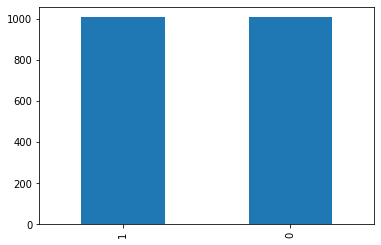

In [ ]:
print('1 Represent- school_Dress, 0 Represent- Normal_Dress \n\n')

df['category'].value_counts().plot.bar()


#**See sample image**

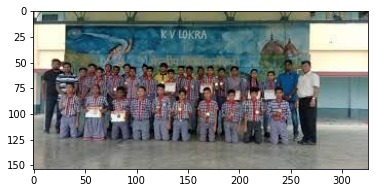

In [ ]:
from PIL import Image
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/Classification Data Set/train/" +sample)
plt.imshow(image)

#**Build Model**

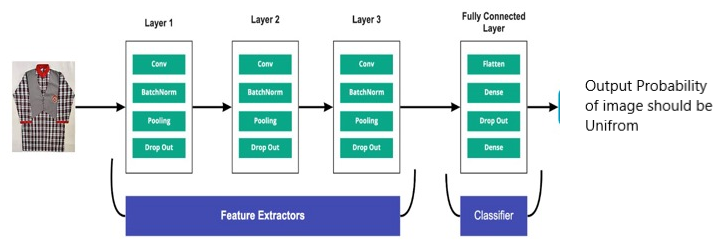

->Input Layer: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.

->Conv Layer: This layer will extract features from image.

->Pooling Layer: This layerreduce the spatial volume of input image after convolution.

->Fully Connected Layer: It connect the network from a layer to another layer

->Output Layer: It is the predicted values layer.


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding= 'same', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have KV-Unifrom and Non-Unifrom classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 62, 62, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 64)       

#**Callbacks**

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#**Early Stop**

**To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased**

In [ ]:
earlystop = EarlyStopping(monitor="val_loss",patience=10)

#**Learning Rate Reduction**

**We will reduce the learning rate when then accuracy not increase for 2 steps**

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
callbacks = [earlystop, learning_rate_reduction]

#**Prepare data**

Use image genaretor with class_mode="categorical". We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

So we will convert 0 to normal dress and 1 to school dress

In [ ]:
df["category"] = df["category"].replace({0: 'normal', 1: 'school'}) 

In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

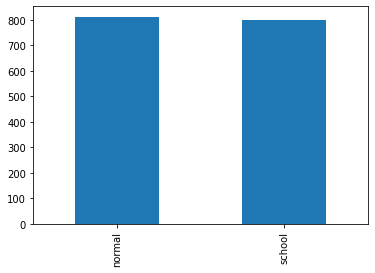

In [ ]:
train_df['category'].value_counts().plot.bar()

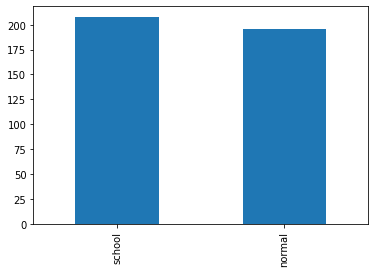

In [ ]:
validate_df['category'].value_counts().plot.bar()

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

#**Traning Generator**

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/drive/MyDrive/Classification Data Set/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1612 validated image filenames belonging to 2 classes.


#**Validation Generator**

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/Classification Data Set/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 404 validated image filenames belonging to 2 classes.


#**See how our generator work**

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/drive/MyDrive/Classification Data Set/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


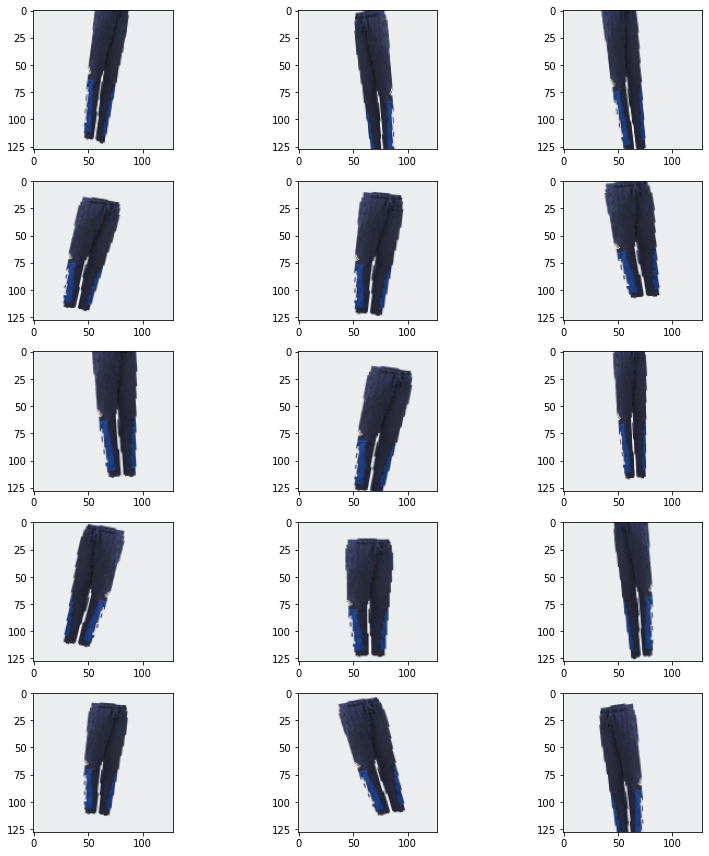

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

#**Fit Model**

In [ ]:
epochs=3 if FAST_RUN else 50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks= callbacks
)

Epoch 1/50
107/107 [==============================] - 749s 7s/step - loss: 1.0011 - accuracy: 0.7422 - val_loss: 1.0488 - val_accuracy: 0.5744
Epoch 2/50
107/107 [==============================] - 27s 251ms/step - loss: 0.5787 - accuracy: 0.8159 - val_loss: 2.2258 - val_accuracy: 0.5000
Epoch 3/50
107/107 [==============================] - 27s 252ms/step - loss: 0.4534 - accuracy: 0.8366 - val_loss: 0.8690 - val_accuracy: 0.7154
Epoch 4/50
107/107 [==============================] - 27s 254ms/step - loss: 0.3368 - accuracy: 0.8665 - val_loss: 0.4651 - val_accuracy: 0.8359
Epoch 5/50
107/107 [==============================] - 27s 249ms/step - loss: 0.3053 - accuracy: 0.8888 - val_loss: 0.2762 - val_accuracy: 0.9026
Epoch 6/50
107/107 [==============================] - 27s 252ms/step - loss: 0.2824 - accuracy: 0.9133 - val_loss: 0.2378 - val_accuracy: 0.9103
Epoch 7/50
107/107 [==============================] - 27s 248ms/step - loss: 0.2303 - accuracy: 0.9101 - val_loss: 0.5479 - val_accu

#**Save Model & Virtualize Training**

[INFO] saving model...

 



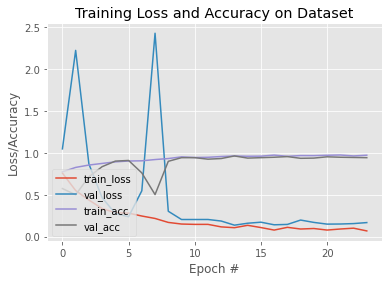

In [ ]:
print("[INFO] saving model...")

model.save_weights("model.h5")
print('\n \n')

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 24), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 24), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 24), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 24), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


#**Prepare Testing Data**

In [ ]:
test_filenames = os.listdir("/content/drive/MyDrive/Classification Data Set/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

#**Create Testing Generator**

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/drive/MyDrive/Classification Data Set/test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 1000 validated image filenames.


#**Predict**

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


**For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max**

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

**We will convert the predict category back into our generator classes by using train_generator.class_indices. It is the classes that image generator map while converting data into computer vision**

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

**From our prepare data part. We map data with {1: 'school dress', 0: 'normal dress'}. Now we will map the result back to school dress is 1 and normal dress is 0**

In [ ]:
test_df['category'] = test_df['category'].replace({ 'school': 1, 'normal': 0 })

#**Virtaulize Result**

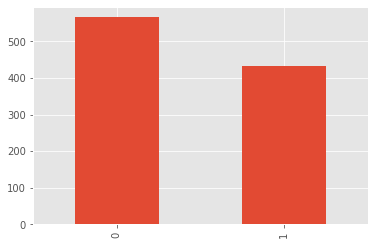

In [ ]:
test_df['category'].value_counts().plot.bar()

#**See predicted result with images**

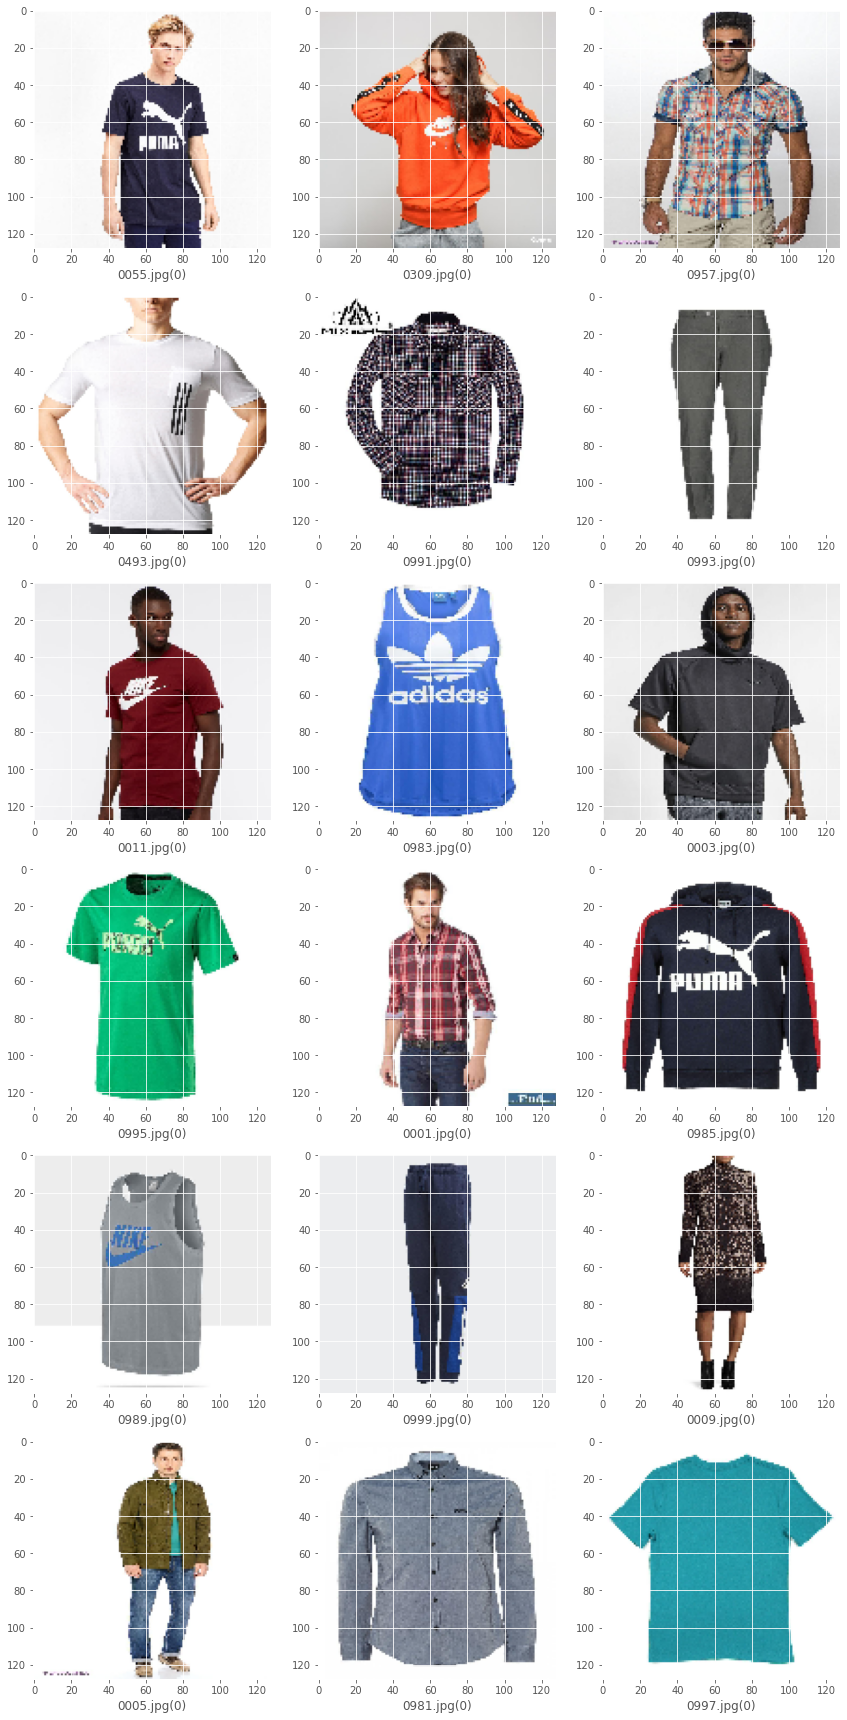

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/drive/MyDrive/Classification Data Set/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)